In [1]:
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import src.realsense.camera as rlc
import open3d as o3d
import rosbag

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [18]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("data/single_layer.bag")
profile = pipe.start(cfg)
playback = profile.get_device().as_playback()
playback.set_real_time(False)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(400):
    pipe.wait_for_frames()

# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


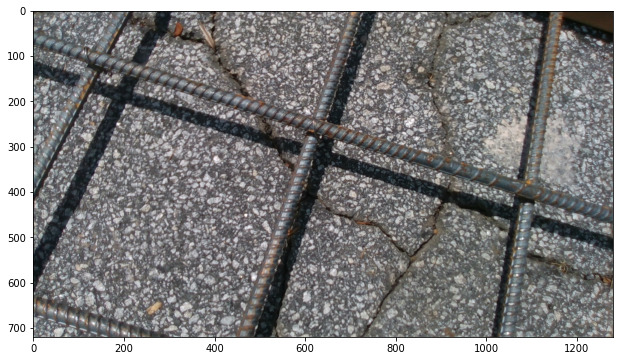

In [19]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

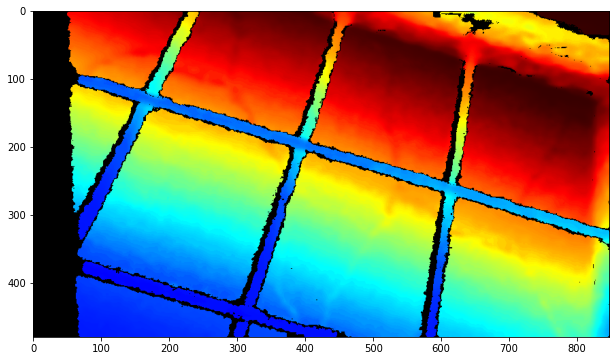

In [20]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

In [21]:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

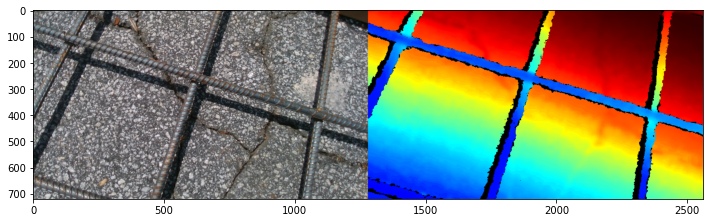

In [22]:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

In [23]:
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = np.asanyarray(aligned_depth_frame.get_data())
depth = depth*depth_scale

print(f"shape of colorized_depth = {colorized_depth.shape}")

shape of colorized_depth = (720, 1280, 3)


In [26]:
bag = rosbag.Bag('data/with_objects_multi_layer.bag')
count_loop = 0

count = 0
for topic, msg, t in bag.read_messages():
#     if 'data' in topic:
#         print(topic)
#     if '/device_0/sensor_0/Depth_0/image/data' in topic:
#         count += 1
    if 'Color_0/info/camera_info' in topic:
        K = msg.K
        D = msg.D
    count_loop +=1
    if count_loop > 20:
        break
print(count)
bag.close()

K = np.array(K).reshape(3,3)
D = np.array(D)
print(f"Distortion : D= {D}")
print(f"Obtained the intrinsics: K= \n{K}")

0
Distortion : D= [0. 0. 0. 0. 0.]
Obtained the intrinsics: K= 
[[915.69732666   0.         627.21875   ]
 [  0.         914.33947754 349.1913147 ]
 [  0.           0.           1.        ]]


In [ ]:
xyz,rgb = rlc.project_rgbd2pcd(color,depth,K) # project to point cloud

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(rgb/255.)
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])